In [26]:
import os
import tqdm

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset

from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

from PIL import Image
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

## Data Exploration

In [27]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # Horizontal Flip
        transforms.RandomHorizontalFlip(),
        # Rotation
        transforms.RandomRotation(20),
        # Scaling
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        # Normalize around mean and std for better convergence
        transforms.Normalize(
            mean=[0.4547, 0.4337, 0.4011], std=[0.2266, 0.2237, 0.2316]
        ),
    ]
)

val_transforms = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

full_dataset = ImageFolder(root="./data/Places2_simp", transform=train_transforms)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# train_dataset.dataset.transform = train_transforms
# val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [28]:
# Total number of scenes for classification
print("Total number of scenes: ", len(os.listdir("./data/Places2_simp")))

Total number of scenes:  40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..1.852647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..2.585924].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..2.5689917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..2.585924].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..2.585924].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..2.585924].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0066195..2.

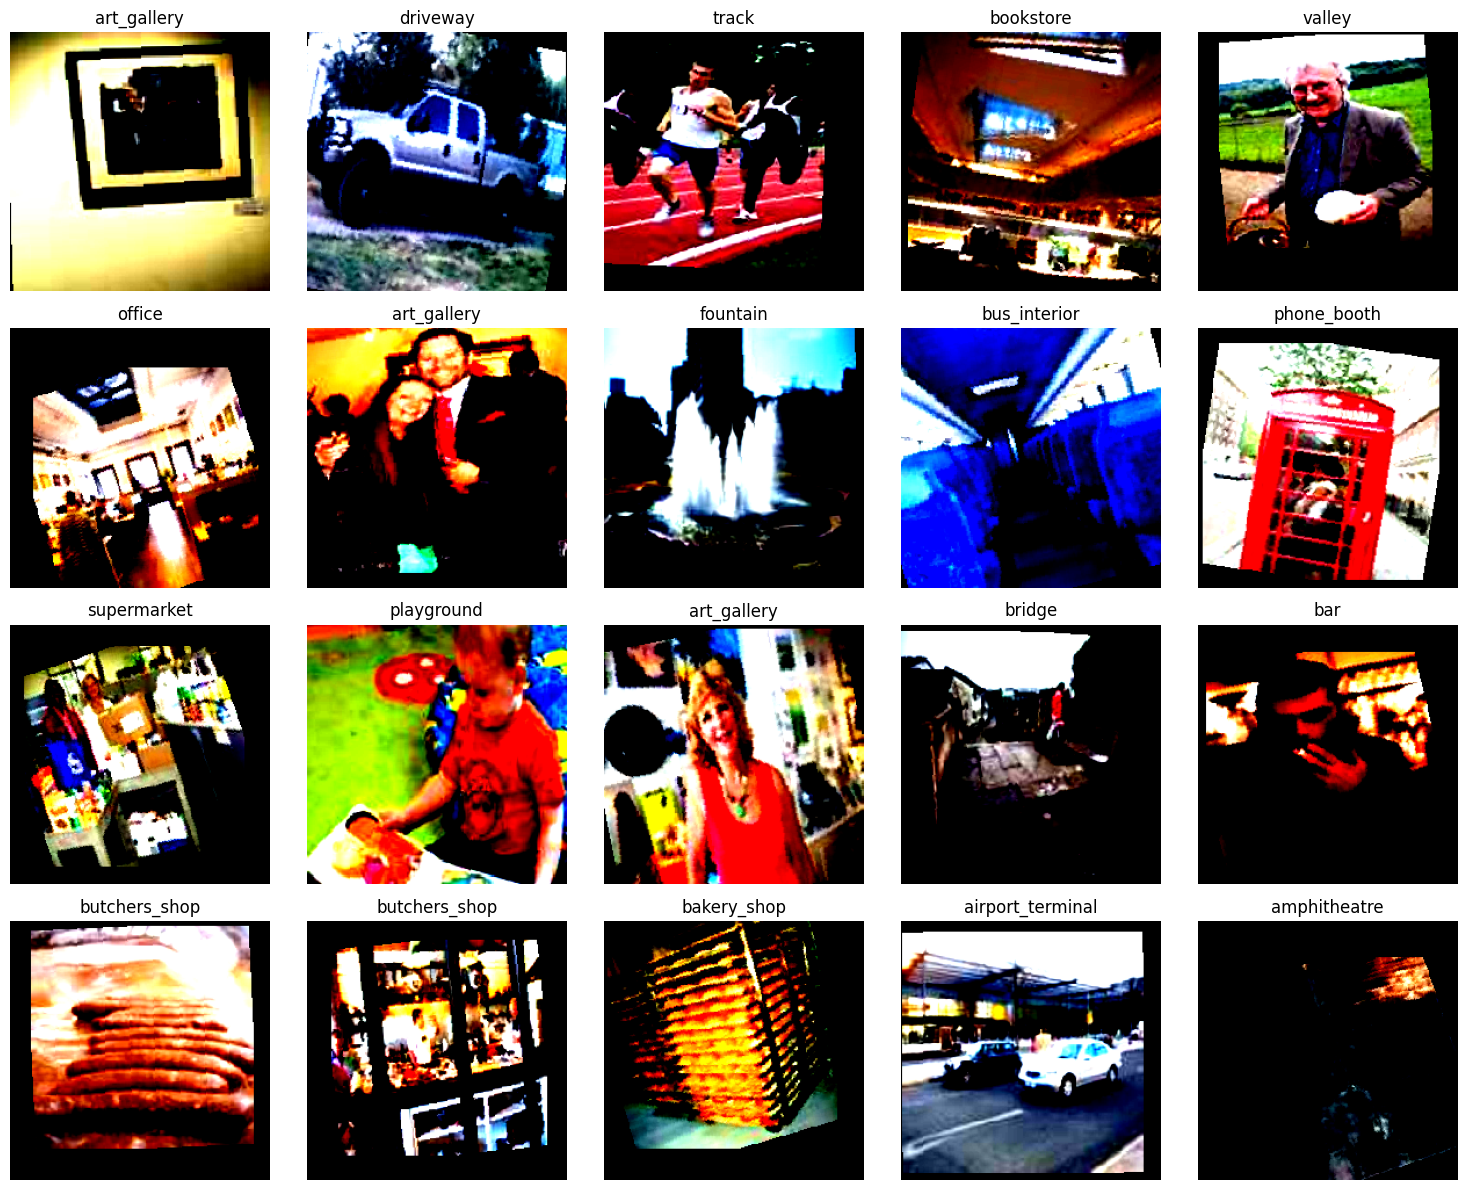

In [ ]:
# Plot random images from dataset
def plot_random_images(images, labels):
    num_images = 15
    cols = 5
    rows = 3

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Get a batch of data
images, labels = next(iter(train_loader))
plot_random_images(images, labels)

In [30]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [31]:
model.classifier.in_features

768

In [22]:
# Remove gradient computation from existing layers
for p in model.parameters():
    p.requires_grad = False

In [23]:
# Replace the last layer with a new linear layer for 40 classes
model.classifier = nn.Linear(768, 40)

In [24]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

lr = 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
batches_per_epoch = len(train_loader)

print(f"\n--- Starting Training Loop ---")

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0

    print(f"Epoch {epoch + 1}/{num_epochs}")

    # pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=True)
    for x, y in train_loader:
        inputs = x.to(device)  # (B, C, H, W)
        labels = y.to(device)  # (B)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values=inputs)  # Pass input with correct kwarg name
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass (calculate gradients)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()
        # pbar.set_postfix({'loss': loss.item()})

    avg_loss = epoch_loss / batches_per_epoch
    print(f"--- Epoch {epoch + 1} Average Loss: {avg_loss:.4f} ---")

print("\nTraining Finished.")

Using device: cuda

--- Starting Training Loop ---
Epoch 1/30


KeyboardInterrupt: 

In [11]:
def evaluate(model, dataloader, device):
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, top5 = outputs.topk(5, dim=1)
            correct_top1 += (top5[:, 0] == labels).sum().item()
            correct_top5 += sum([label in top for label, top in zip(labels, top5)])
            total += labels.size(0)

    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total
    return top1_acc, top5_acc

In [12]:
evaluate(model, test_loader, "cuda")

(63.475, 89.75)

In [13]:
def evaluate10(model, dataloader, device):
    model.eval()
    correct_top1 = 0
    correct_top3 = 0
    correct_top5 = 0
    correct_top10 = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            _, topk = outputs.topk(10, dim=1)  # Get top 10 predictions for each sample

            labels = labels.view(-1, 1)
            correct = topk.eq(labels)

            correct_top1 += correct[:, :1].sum().item()
            correct_top3 += correct[:, :3].sum().item()
            correct_top5 += correct[:, :5].sum().item()
            correct_top10 += correct[:, :10].sum().item()
            total += labels.size(0)

    top1_acc = 100 * correct_top1 / total
    top3_acc = 100 * correct_top3 / total
    top5_acc = 100 * correct_top5 / total
    top10_acc = 100 * correct_top10 / total

    return top1_acc, top3_acc, top5_acc, top10_acc

In [14]:
evaluate10(model, test_loader, "cuda")

(63.025, 82.775, 90.0, 96.125)

In [15]:
def plot_confusion_matrix(
    model, dataloader, class_names, device, save_path="confusion_matrix.png"
):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(pixel_values=images).logits
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(16, 12))  # Increased size

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
    )
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

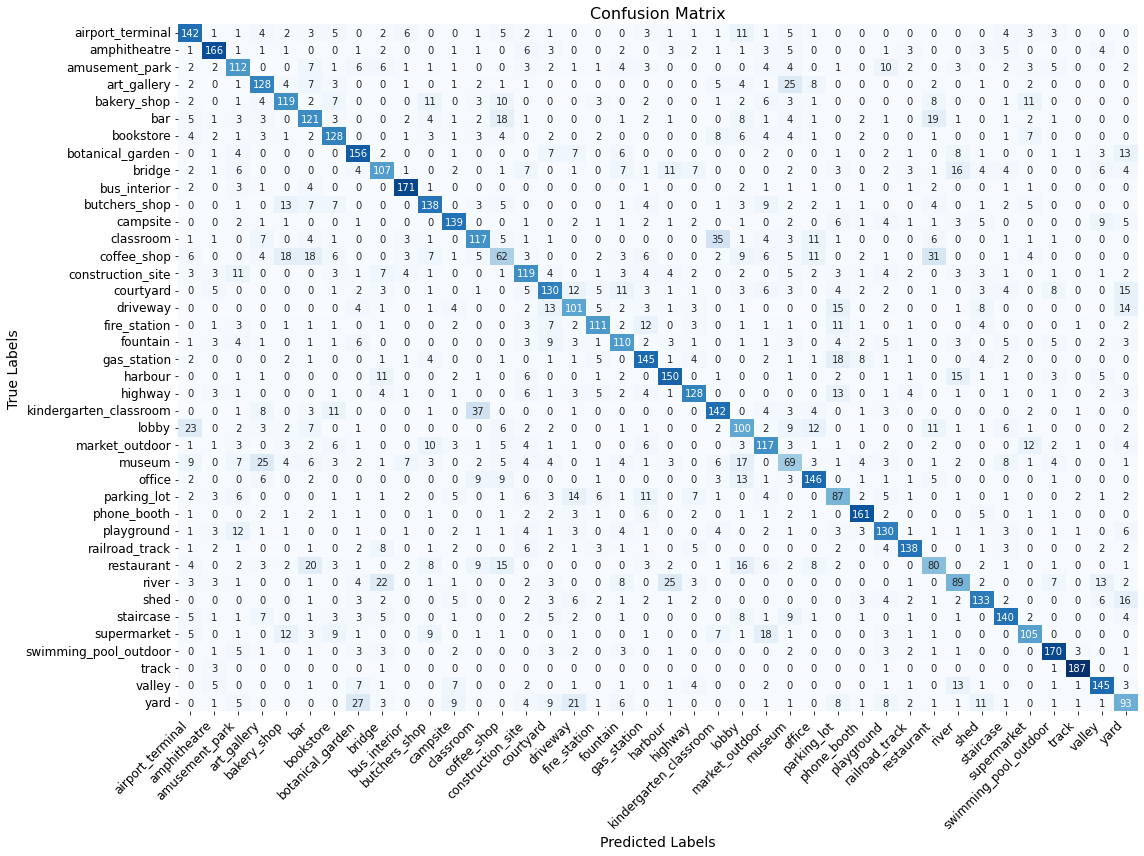

In [16]:
plot_confusion_matrix(
    model, test_loader, class_names, "cuda", save_path="confusion_matrix.png"
)

In [17]:
def show_top_misclassified_images(model, dataloader, class_names, device, top_k=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(pixel_values=images).logits
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(images.size(0)):
                true = labels[i].item()
                pred = preds[i].item()
                if true != pred:
                    confidence = probs[i][pred].item()
                    misclassified.append(
                        {
                            "image": images[i].cpu(),
                            "true": true,
                            "pred": pred,
                            "confidence": confidence,
                        }
                    )

    # Sort by highest wrong confidence
    misclassified = sorted(misclassified, key=lambda x: x["confidence"], reverse=True)[
        :top_k
    ]

    for i, entry in enumerate(misclassified):
        img = entry["image"].permute(1, 2, 0).numpy()
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(
            f"❌ {i + 1}\nTrue: {class_names[entry['true']]}\nPred: {class_names[entry['pred']]}\nConf: {entry['confidence']:.2f}"
        )
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_297044/1936374004.py:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


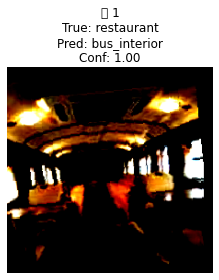

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


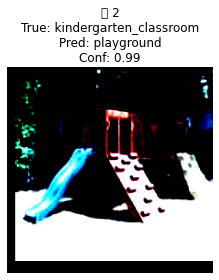

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


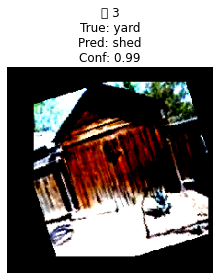

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


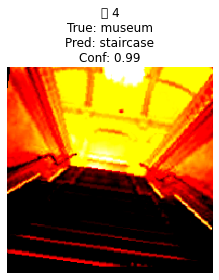

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


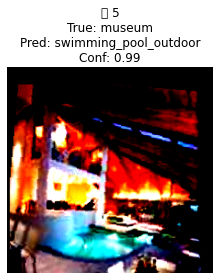

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


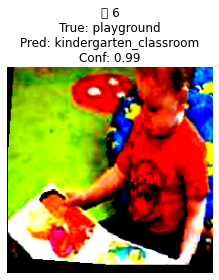

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


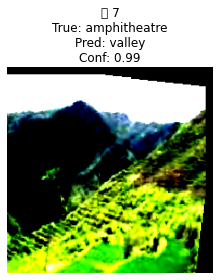

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


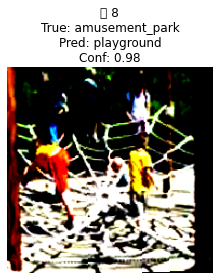

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


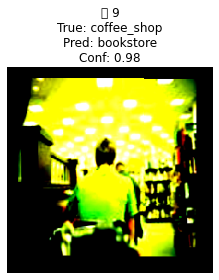

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


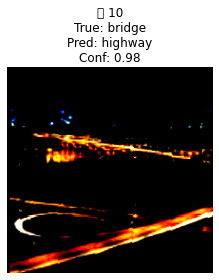

In [18]:
show_top_misclassified_images(model, test_loader, class_names, device, top_k=10)